In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import tensorflow as tf
import os

sys.path.append("../../bioseg")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
sess = tf.InteractiveSession()

## Load Dataset

In [3]:
dataset_folder = '/data/natalia/intern20/PaperData/MIBI_1channel/'

n_scribbles = 200
dataset_path = dataset_folder + 'dataset_bioseg_noaug_n'+str(n_scribbles)+'.npz'

Training shape (X,Y)
(120, 128, 128, 1) (120, 128, 128, 2)
Validation (X,Y)
(32, 128, 128, 1) (32, 128, 128, 2)

----- Plot Patches Train Dataset -----


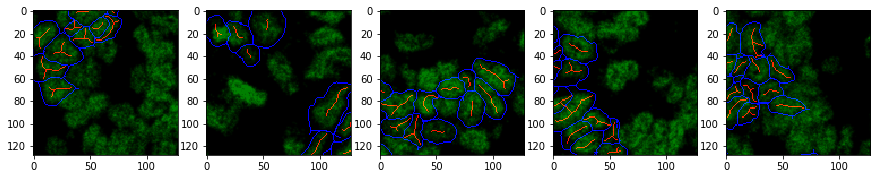


----- Plot Patches Validation Dataset -----


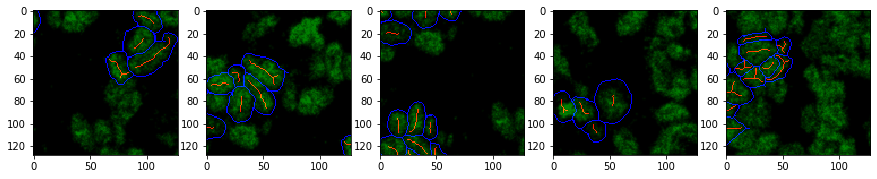

In [4]:
## Plot some patches ##
npz_file = np.load(dataset_path)

X_train = npz_file['X_train']
Y_train = npz_file['Y_train']
X_val = npz_file['X_val']
Y_val = npz_file['Y_val']

print('Training shape (X,Y)')
print(X_train.shape, Y_train.shape)
print('Validation (X,Y)')
print(X_val.shape, Y_val.shape)

print()
print('----- Plot Patches Train Dataset -----')
index = np.arange(Y_train.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_train[ix,:,:,0][...,np.newaxis],
                               0.5*X_train[ix,:,:,0][...,np.newaxis],
                               Y_train[ix,:,:,1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
plt.show()

print()
print('----- Plot Patches Validation Dataset -----')
index = np.arange(Y_val.shape[0])
np.random.shuffle(index)
cont = 1
plt.figure(figsize = (15,4))
for ix in index[0:5]:
    img_plot = np.concatenate([Y_val[ix,:,:,0][...,np.newaxis],
                               0.5*X_val[ix,:,:,0][...,np.newaxis],
                               Y_val[ix,:,:,1][...,np.newaxis]],axis = -1)
    
    plt.subplot(1,5,cont)
    cont += 1
    plt.imshow(img_plot)
plt.show()


## Set Model

In [5]:
basedir = '/data/natalia/intern20/model/MIBI_1channel/'
model_name = 'BioSeg_n'+str(n_scribbles)

## Config file generation
from BioSeg_config import *
BioConfig = BioSegConfig(X_train,train_epochs=50)
print(BioConfig)

BioSegConfig(axes='YXC', batch_norm=False, channel_denoised=False, distributions='gauss', fit_mean=True, fit_std=False, means=['0.19507612'], multi_objective=True, n2v_leave_center=False, n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, n2v_patch_shape=(128, 128), n2v_perc_pix=1.5, n_back_i_modes=1, n_back_modes=2, n_channel_in=1, n_channel_out=8, n_components=2, n_dim=2, n_fore_i_modes=1, n_fore_modes=2, n_instance_seg=0, normalizer='none', probabilistic=False, scale_aug=False, single_net_per_channel=False, stds=['0.26219767'], structN2Vmask=None, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=50, train_learning_rate=0.0004, train_loss='demix', train_reduce_lr={'monitor': 'val_loss', 'factor': 0.5, 'patience': 10}, train_steps_per_epoch=50, train_tensorboard=False, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_

Using TensorFlow backend.


In [6]:
from BioSeg_models import set_bioseg_model,model_trainer_fc

## create model
model = set_bioseg_model(basedir, model_name, BioConfig)
trainer_fc = model_trainer_fc(model) #trainer function

------------------  BioSeg setup  -------------------------
basedir/model name :  /data/natalia/intern20/model/MIBI_1channel/BioSeg_n200
model file :  /data/natalia/intern20/model/MIBI_1channel/BioSeg_n200/weights_best.h5

** Create Model **

BioSegConfig(axes='YXC', batch_norm=False, channel_denoised=False, distributions='gauss', fit_mean=True, fit_std=False, means=['0.19507612'], multi_objective=True, n2v_leave_center=False, n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, n2v_patch_shape=(128, 128), n2v_perc_pix=1.5, n_back_i_modes=1, n_back_modes=2, n_channel_in=1, n_channel_out=8, n_components=2, n_dim=2, n_fore_i_modes=1, n_fore_modes=2, n_instance_seg=0, normalizer='none', probabilistic=False, scale_aug=False, single_net_per_channel=False, stds=['0.26219767'], structN2Vmask=None, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=50, train_learning_rate=0.0004, train_

/home/natalia/anaconda3/envs/biointern20/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /mnt/data0/natalia/intern20/model/MIBI_1channel/BioSeg_n200
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))



Model with random initialization


### Training 

In [7]:
from seg_trainer import train_model
from time import time

starttime = time()
save_data = train_model(trainer_fc,dataset_path=dataset_path, augment=True)
endtime = time()

Training model ---- 
dataset :  /data/natalia/intern20/PaperData/MIBI_1channel/dataset_bioseg_noaug_n200.npz


../../bioseg/BioSeg_models.py:272: UserWarning: small number of validation images (only 3.2% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))
Preparing validation data:  22%|██▏       | 7/32 [00:00<00:00, 61.85it/s]

### SUMMARY DATA ###
training
(960, 128, 128, 1) (960, 128, 128, 2)
fraction train patches with annotations :  0.9833333333333333
Validation
(32, 128, 128, 1) (32, 128, 128, 2)
fraction val patches with annotations :  0.96875
True
245 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|██████████| 32/32 [00:00<00:00, 61.69it/s]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50




50/50 [==============================] - 55s 1s/step - loss: 0.2188 - rec: 0.9560 - entropy: 0.4547 - multich_seg_error: 0.0000e+00 - seg_error: 0.1369 - val_loss: 0.1691 - val_rec: 0.9376 - val_entropy: 0.2388 - val_multich_seg_error: 0.0000e+00 - val_seg_error: 0.0837
Epoch 2/50
50/50 [==============================] - 52s 1s/step - loss: 0.1681 - rec: 0.9374 - entropy: 0.2096 - multich_seg_error: 0.0000e+00 - seg_error: 0.0826 - val_loss: 0.1542 - val_rec: 0.9367 - val_entropy: 0.1794 - val_multich_seg_error: 0.0000e+00 - val_seg_error: 0.0673
Epoch 3/50
50/50 [==============================] - 54s 1s/step - loss: 0.1510 - rec: 0.9355 - entropy: 0.1642 - multich_seg_error: 0.0000e+00 - seg_error: 0.0638 - val_loss: 0.1384 - val_rec: 0.9317 - val_entropy: 0.1504 - val_multich_seg_error: 0.0000e+00 - val_seg_error: 0.0503
Epoch 4/50
50/50 [==============================] - 5

In [8]:
print(endtime - starttime)

2682.759871482849


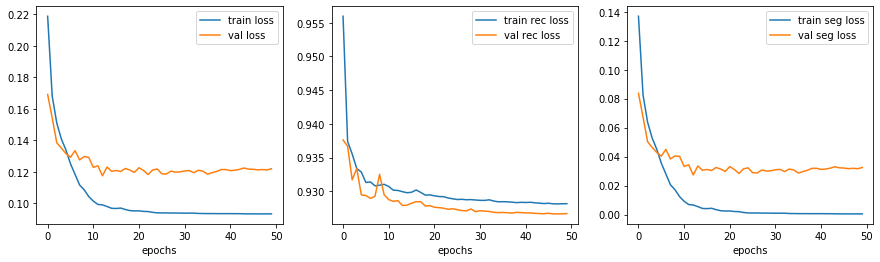

In [9]:
history = save_data['history']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,3,2)
plt.plot(history['rec'],label='train rec loss')
plt.plot(history['val_rec'],label='val rec loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,3,3)
plt.plot(history['seg_error'],label='train seg loss')
plt.plot(history['val_seg_error'],label='val seg loss')
plt.xlabel('epochs')
plt.legend()

plt.show()

## Evaluation

In [10]:
pd_train = pd.read_csv(dataset_folder + 'files.csv',index_col=0)
pd_train

,prefix,input_dir,input_file,group
0,image0,/data/natalia/intern20/PaperData/MIBI_1channel/,image0.npz,train
1,image1,/data/natalia/intern20/PaperData/MIBI_1channel/,image1.npz,test
2,image2,/data/natalia/intern20/PaperData/MIBI_1channel/,image2.npz,test
3,image3,/data/natalia/intern20/PaperData/MIBI_1channel/,image3.npz,train
4,image4,/data/natalia/intern20/PaperData/MIBI_1channel/,image4.npz,test
5,image5,/data/natalia/intern20/PaperData/MIBI_1channel/,image5.npz,train
6,image6,/data/natalia/intern20/PaperData/MIBI_1channel/,image6.npz,test
7,image7,/data/natalia/intern20/PaperData/MIBI_1channel/,image7.npz,train


In [11]:
from BioSeg_models import model_evaluation_fc
from BioSeg_postprocess import single_channel_evaluation,get_performance,get_best_th,get_best,get_stats_th
model_evaluation = model_evaluation_fc(model, perc_normalization=False)

ix_fg = list(np.arange(model.config.n_fore_modes))

### Test evaluation ###
Y_est_test_list, Y_gt_test_list, X_test_list, prefix_test = single_channel_evaluation(pd_train, model_evaluation,
                                                                                          tag='channel_0',
                                                                                      ix_fg_list=ix_fg,
                                                                                      group='test')

### Train evaluation ###
Y_est_train_list, Y_gt_train_list, X_train_list, prefix_train = single_channel_evaluation(pd_train, model_evaluation,
                                                                                          tag='channel_0',
                                                                                      ix_fg_list=ix_fg,
                                                                                      group='train')

Evaluation :  test ; from sample  0  to  4
Evaluation :  train ; from sample  0  to  4


In [12]:
### performance ###
th_list = np.linspace(0, 1, 21)[1:-1]
pd_stats_train = get_performance(Y_est_train_list, Y_gt_train_list, th_list=th_list)
pd_stats_train['group'] = 'train'
pd_stats_train['prefix'] = list(np.array(prefix_train)[pd_stats_train['index'].values.astype('int'), 0])

print()
best_value,best_th = get_best_th(pd_stats_train,metric_list=['IoU','Dice','Acc'])
print('Best Value, Threshold : ',best_value, best_th)

print()
print('Train Performance :: ')
pd_best_train = get_stats_th(pd_stats_train,best_th,metric_list=['IoU','Dice','Acc'])
print(pd_best_train)

Evaluation i/nsamples
0 4
1 4
2 4
3 4

Best Value, Threshold :  {'IoU': 0.5892173209986508, 'Dice': 0.7113136481535458, 'Acc': 0.87849375} {'IoU': 0.8500000000000001, 'Dice': 0.9, 'Acc': 0.05}

Train Performance :: 
        IoU      Dice       Acc       auc  group  prefix
0  0.608193  0.731416  0.858625  0.963513  train  image0
1  0.608276  0.722671  0.857656  0.960583  train  image3
2  0.455734  0.594246  0.832244  0.951403  train  image5
3  0.684666  0.796922  0.965450  0.985581  train  image7


In [13]:
pd_stats_test = get_performance(Y_est_test_list, Y_gt_test_list, th_list=[best_th[ix] for ix in best_th.keys()])
pd_stats_test['group'] = 'test'
pd_stats_test['prefix'] = list(np.array(prefix_test)[pd_stats_test['index'].values.astype('int'), 0])

print()
pd_best_test = get_stats_th(pd_stats_test,best_th,metric_list=['IoU','Dice','Acc'])
print('Test Performance :: ')
print(pd_best_test)

Evaluation i/nsamples
0 4
1 4
2 4
3 4

Test Performance :: 
        IoU      Dice       Acc       auc group  prefix
0  0.532757  0.645306  0.858437  0.956629  test  image1
1  0.755468  0.832701  0.949831  0.987356  test  image2
2  0.622423  0.717474  0.877456  0.968572  test  image4
3  0.546571  0.671810  0.858131  0.969809  test  image6


## Plots

In [14]:
plot_scribbles = True
if plot_scribbles:
    pd_scribbles = pd.read_csv(dataset_folder+'files_scribbles_train_'+str(int(n_scribbles))+'.csv') 
#we want to plot the scribbles

IoU       0.608193
Dice      0.731416
Acc       0.858625
auc       0.963513
group        train
prefix      image0
Name: 0, dtype: object


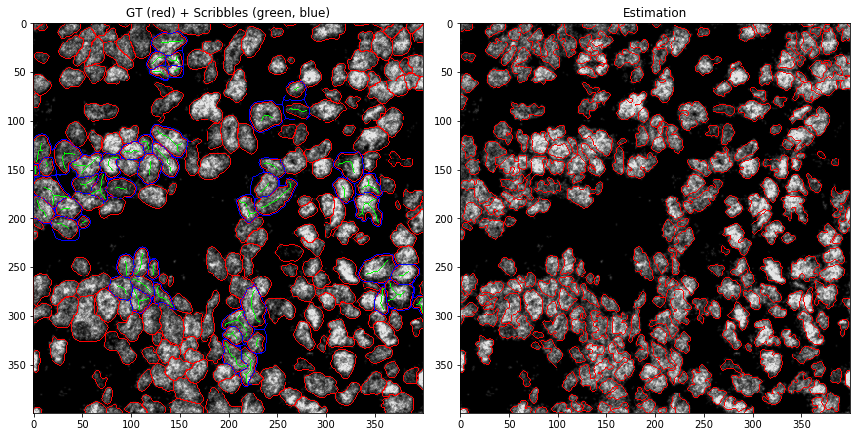

In [20]:
from BioSeg_postprocess import get_seg_image

i=0
print(pd_best_train.iloc[i])

implot_gt = get_seg_image(X_train_list[i],Y_gt_train_list[i])
implot_est = get_seg_image(X_train_list[i],Y_est_train_list[i],th = best_th['Dice'])

if plot_scribbles:
    prefix = pd_best_train.iloc[i]['prefix']
    input_dir = pd_scribbles.loc[pd_scribbles['prefix'] == prefix]['input_dir'].values[0]
    scribble_file = pd_scribbles.loc[pd_scribbles['prefix'] == prefix]['scribble_file'].values[0]

    npz_read = np.load(input_dir + scribble_file)
    scribble = npz_read['scribble']

    implot_gt = implot_gt*(1-np.sum(scribble,axis=-1)[...,np.newaxis])
    implot_gt[...,1] += scribble[...,0]
    implot_gt[...,2] += np.sum(scribble[...,1:],axis = -1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('GT (red) + Scribbles (green, blue)')
plt.imshow(implot_gt)
plt.subplot(1,2,2)
plt.title('Estimation')
plt.imshow(implot_est)
plt.tight_layout()
plt.show()

IoU       0.755468
Dice      0.832701
Acc       0.949831
auc       0.987356
group         test
prefix      image2
Name: 1, dtype: object


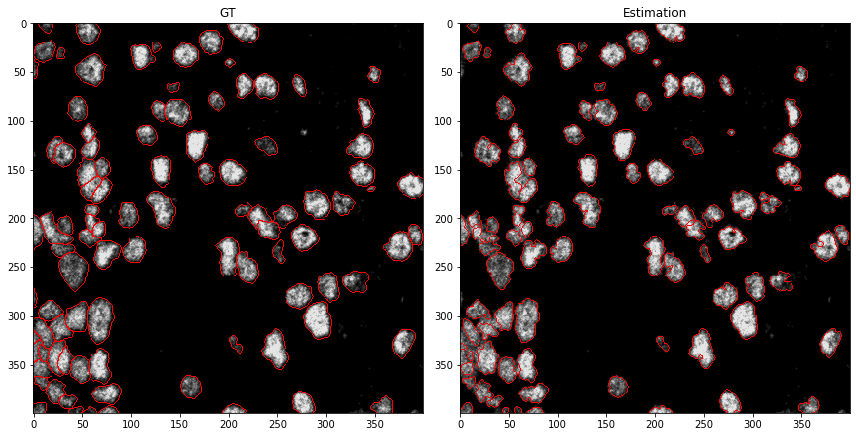

In [21]:
#Test (no scribbles patches)
from BioSeg_postprocess import get_seg_image
# for i in range(len(X_test_list)):
i = 1 
print(pd_best_test.iloc[i])

implot_gt = get_seg_image(X_test_list[i],Y_gt_test_list[i])
implot_est = get_seg_image(X_test_list[i],Y_est_test_list[i],th = best_th['Dice'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('GT')
plt.imshow(implot_gt)
plt.subplot(1,2,2)
plt.title('Estimation')
plt.imshow(implot_est)
plt.tight_layout()
plt.show()



In [17]:
print(pd_best_train)
print(pd_best_test)

        IoU      Dice       Acc       auc  group  prefix
0  0.608193  0.731416  0.858625  0.963513  train  image0
1  0.608276  0.722671  0.857656  0.960583  train  image3
2  0.455734  0.594246  0.832244  0.951403  train  image5
3  0.684666  0.796922  0.965450  0.985581  train  image7
        IoU      Dice       Acc       auc group  prefix
0  0.532757  0.645306  0.858437  0.956629  test  image1
1  0.755468  0.832701  0.949831  0.987356  test  image2
2  0.622423  0.717474  0.877456  0.968572  test  image4
3  0.546571  0.671810  0.858131  0.969809  test  image6
